<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install einops

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from einops.layers.torch import Reduce
import ipdb

device = "cuda" if torch.cuda.is_available() else "cpu"

trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="dataset/", transform=trans, download=True, train=True) # 6W张图片 1,28,28
loader = DataLoader(dataset, batch_size=60, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(image.shape, label.shape) # 60,1,28,28; 60

fig, axs = plt.subplots(1, 3, figsize=(3, 1))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(image[i][0].cpu(), cmap='gray')
plt.tight_layout()
plt.show()

In [30]:
# https://www.jianshu.com/p/06a40338dc7c
class PatchEmbedding(nn.Module): # 省略了位置编码和分类token
  def __init__(self, patch_size: int = 4, emb_size: int = 40):
      self.patch_size = patch_size
      super().__init__()
      self.conv = nn.Conv2d(1, emb_size, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
      b, _, _, _ = x.shape # 60,1,28,28
      x = self.conv(x) # => 60,40,7,7
      x = rearrange(x, 'b e (h) (w) -> b (h w) e') # => 60,49,40
      return x # 60,49,40

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 40, num_heads: int = 4, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x):
    x = self.qkv(x) # 60,49,40 => 60,49,120
    qkv = rearrange(x, "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # => 3,60,4,49,10
    queries, keys, values = qkv[0], qkv[1], qkv[2] # => 60,4,49,10
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # => 60,4,49,49
    scaling = self.emb_size ** (1/2)
    att = nn.functional.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav ', att, values) # => 60,4,49,10
    out = rearrange(out, "b h n d -> b n (h d)") # => 60,49,40
    out = self.projection(out) # => 60,49,40
    return out

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    res = x
    x = self.fn(x)
    x += res
    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
      nn.Linear(emb_size, expansion * emb_size),
      nn.GELU(),
      nn.Dropout(drop_p),
      nn.Linear(expansion * emb_size, emb_size),
    )

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,emb_size: int = 40,drop_p: float = 0.):
    super().__init__(
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        MultiHeadAttention(),
        nn.Dropout(drop_p)
      )),
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        FeedForwardBlock(emb_size),
        nn.Dropout(drop_p)
      )
      ))

class TransformerEncoder(nn.Sequential):
  def __init__(self, depth: int = 4):
    super().__init__(*[TransformerEncoderBlock() for _ in range(depth)])

class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 40, n_classes: int = 10):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'), # 60,49,40 => 60,40
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes)) # 60,40 => 60,10

class ViT(nn.Sequential):
  def __init__(self):
    super().__init__(
      PatchEmbedding(),
      TransformerEncoder(),
      ClassificationHead()
    )

In [31]:
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for epoch in range(1,3):
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(batch_idx % 100 == 99):
      print("Loss at {}th epoch{}: {}".format(batch_idx, epoch, loss))

Loss at 99th epoch1: 2.0495927333831787
Loss at 199th epoch1: 1.798142671585083
Loss at 299th epoch1: 1.7428439855575562
Loss at 399th epoch1: 1.5379589796066284
Loss at 499th epoch1: 1.5024904012680054
Loss at 599th epoch1: 1.4898570775985718
Loss at 699th epoch1: 1.4182103872299194
Loss at 799th epoch1: 1.3776017427444458
Loss at 899th epoch1: 1.1188828945159912
Loss at 999th epoch1: 1.356502652168274
Loss at 99th epoch2: 1.2426750659942627
Loss at 199th epoch2: 1.3283993005752563
Loss at 299th epoch2: 1.1344807147979736
Loss at 399th epoch2: 1.1343073844909668
Loss at 499th epoch2: 1.2448585033416748
Loss at 599th epoch2: 1.1536638736724854
Loss at 699th epoch2: 1.0153676271438599
Loss at 799th epoch2: 0.9464353919029236
Loss at 899th epoch2: 0.8588830828666687
Loss at 999th epoch2: 1.122531771659851


In [32]:
trans_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_test = datasets.MNIST(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

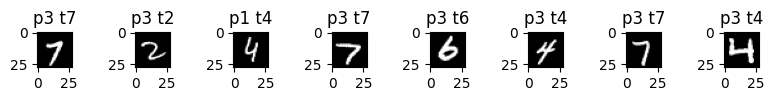

batch 9, loss 2.7099331855773925, error 815/1000


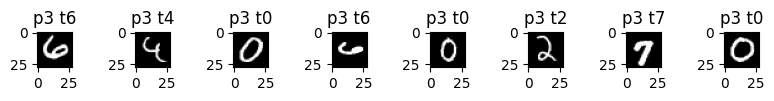

batch 19, loss 2.712126338481903, error 1627/2000


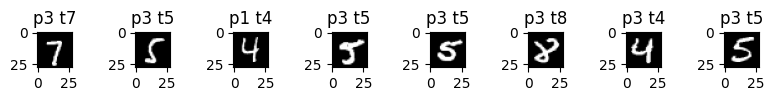

batch 29, loss 2.6949354569117228, error 2425/3000


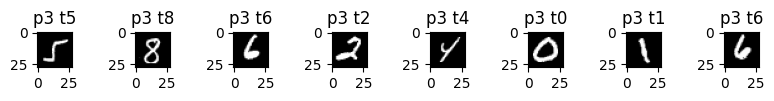

batch 39, loss 2.6973410189151763, error 3249/4000


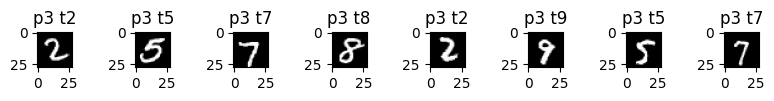

batch 49, loss 2.6851178789138794, error 4033/5000


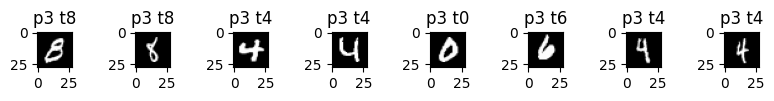

batch 59, loss 2.6892663558324177, error 4839/6000


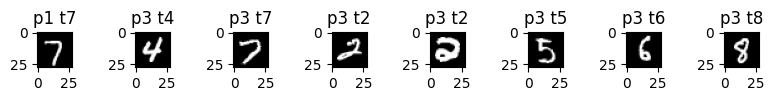

batch 69, loss 2.682204372542245, error 5626/7000


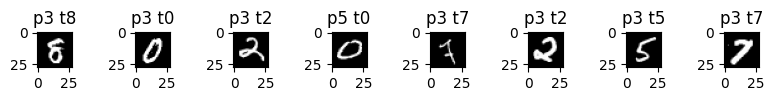

batch 79, loss 2.6897270321846007, error 6448/8000


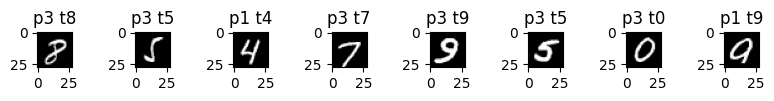

batch 89, loss 2.6912623484929403, error 7247/9000


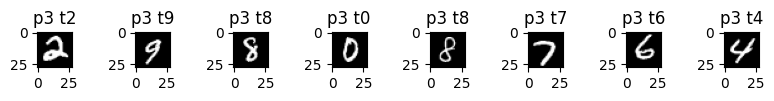

batch 99, loss 2.68935756444931, error 8050/10000


In [34]:
total_loss = []
errorTotal = 0
for batch_idx, (img, label) in enumerate(loader_test): # 1W张图片, 100批, 100,1,28,28
  img = img.to(device)
  label = label.to(device)

  output = model(img)
  loss = criterion_test(output, label)
  total_loss.append(loss.item())

  maxV,maxIdx = output.max(dim=1)
  errorNum = torch.sum(torch.ne(maxIdx, label)).item()
  errorTotal += errorNum

  noMatchIdx = torch.nonzero(torch.ne(maxIdx, label)).view(-1)

  if(batch_idx % 10 == 9):
    if errorNum > 8:
      errorNum = 8
    fig, axs = plt.subplots(1, errorNum, figsize=(errorNum, 1))
    for i, ax in enumerate(axs.flatten()):
      idx = noMatchIdx[i]
      ax.imshow(img[idx][0].cpu(), cmap='gray')
      ax.set_title('p{} t{}'.format(maxIdx[idx], label[idx]))
    plt.tight_layout()
    plt.show()
    print("batch {}, loss {}, error {}/{}".format(batch_idx, np.mean(total_loss), errorTotal, (batch_idx+1) * 100))